In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as Func
import timm
import cv2
import shutil
import zipfile

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 if torch.cuda.is_available() else 0
print(device)

cuda


## Load NestedUnet and pixel size models

In [3]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class NestedUNet(nn.Module):
    def __init__(self, n_channels, n_classes, deep_supervision=False):
        super(NestedUNet, self).__init__()
        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]

        self.conv0_0 = double_conv(n_channels, nb_filter[0])
        self.conv1_0 = double_conv(nb_filter[0], nb_filter[1])
        self.conv2_0 = double_conv(nb_filter[1], nb_filter[2])
        self.conv3_0 = double_conv(nb_filter[2], nb_filter[3])
        self.conv4_0 = double_conv(nb_filter[3], nb_filter[4])

        self.conv0_1 = double_conv(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = double_conv(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = double_conv(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = double_conv(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = double_conv(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = double_conv(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = double_conv(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = double_conv(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = double_conv(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = double_conv(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)

        self.sigmoid = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(F.max_pool2d(x0_0, 2))
        x2_0 = self.conv2_0(F.max_pool2d(x1_0, 2))
        x3_0 = self.conv3_0(F.max_pool2d(x2_0, 2))
        x4_0 = self.conv4_0(F.max_pool2d(x3_0, 2))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.sigmoid(self.final1(x0_1))
            output2 = self.sigmoid(self.final2(x0_2))
            output3 = self.sigmoid(self.final3(x0_3))
            output4 = self.sigmoid(self.final4(x0_4))
            return [output1, output2, output3, output4]

        else:
            output = self.sigmoid(self.final(x0_4))
            return output

In [4]:
# Define the model architecture
model = NestedUNet(1, 1)

# Load the state dictionary
model.load_state_dict(torch.load('/kaggle/input/fetalhcdata/segmentation_models/segmentation_UNET++.pth', map_location=device))

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)
model.eval()

print("UNET model loaded")

UNET model loaded


In [5]:
ps_model_pth  = torch.load('/kaggle/input/fetalhcdata/ps_model_effnetb0.pth', map_location=device)
ps_model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=1, in_chans=1)
ps_model.load_state_dict(ps_model_pth)
ps_model.to(device)
ps_model.eval()

print("Pixel Model Loaded")

Pixel Model Loaded


## Circumference, OFD, and BPD Calculation Method

In [6]:
def calculate_circumference(ellipse, indx, test_df):

    # Retrieve pixel size for the given file name
    pixel_size = test_df.at[indx, 'pixel size(mm)']
    
    # Calculate and append ellipse parameters to submission
    center_x, center_y = ellipse[0]
    center_x_mm = pixel_size * center_x
    center_y_mm = pixel_size * center_y
    
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    
    semi_axes_a_mm = semi_axes_a * pixel_size / 2
    semi_axes_b_mm = semi_axes_b * pixel_size / 2
    
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    
    angle_rad = np.deg2rad(angle)
    
    OFD = np.round(semi_axes_a_mm*2,1)
    BPD = np.round(semi_axes_b_mm*2,1)
    b = np.round(BPD,1)
    c= np.round(OFD,1)

    d = b+c
    e=d*d*d
    f=(1.62*e)
    g=np.round(f**(1/3),1)
    Head_Circumfrence_cm = g/10
    
    return Head_Circumfrence_cm, OFD, BPD

def test_ellipse(imgray):
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    if len(largest_contour) < 5:
        return None
    ellipse = cv2.fitEllipse(largest_contour)
    return ellipse

## Load csv and predict pixel size if not included

In [7]:
from tqdm import tqdm

img_size = 512

transform_X = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_pixel_size(image_path):
    # Open the image
    image = Image.open(image_path)
    # Apply the transformations
    image = transform_X(image)
    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pixel_size = ps_model(image).item()
    
    return pixel_size
    
def create_image_df(folder_path, csv_with_pixel_sizes=None, exclude_pixel_size_column=False):
    if csv_with_pixel_sizes is None:
        # List to store image names and predicted pixel sizes
        image_names = []
        pixel_sizes = []

        # Loop through all files in the directory
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                    image_path = os.path.join(root, file)
                    image_names.append(file)
                    # Predict the pixel size
                    pixel_size = predict_pixel_size(image_path)
                    pixel_sizes.append(pixel_size)
                    
        return pd.DataFrame({'filename': image_names, 'pixel size(mm)': pixel_sizes})
    
    else:
        df = pd.read_csv(csv_with_pixel_sizes)
        if exclude_pixel_size_column:
            # Drop the 'pixel size(mm)' column if it exists
            if 'pixel size(mm)' in df.columns:
                df.drop(columns=['pixel size(mm)'], inplace=True)
                
            # Predict new pixel sizes for each image
            pixel_sizes = []
            for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing CSV rows", leave=True):
                image_path = os.path.join(folder_path, row['filename'])
                pixel_size = predict_pixel_size(image_path)
                pixel_sizes.append(pixel_size)
            
            df['pixel size(mm)'] = pixel_sizes
        
        return df

# Define paths
dirPath = 'testdir/'
img_dir = '/kaggle/input/testingdataset/training_set'
csv_with_pixel_size_path = '/kaggle/input/testingdataset/training_set_circumference.csv'

# Create a data frame with image names
test_df = create_image_df(img_dir, csv_with_pixel_size_path)
test_df.head()

,filename,pixel size(mm),Head_Circumference_mm,Head_Circumference_cm,mask_filename
0,000_HC.png,0.069136,44.30,4.430,000_HC_Mask.png
1,001_HC.png,0.089659,56.81,5.681,001_HC_Mask.png
2,012_HC.png,0.083460,59.40,5.940,012_HC_Mask.png
3,004_HC.png,0.061240,59.81,5.981,004_HC_Mask.png
4,014_3HC.png,0.077308,60.26,6.026,014_3HC_Mask.png


In [8]:
class ImagesSet(Dataset):
    def __init__(self, img_dir, df, transform_X=None):
        self.X_train = [os.path.join(img_dir, filename) for filename in df['filename']]
        self.img_names = [filename for filename in df['filename']]
        self.transform_X = transform_X

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        X_path = self.X_train[idx]
        X = Image.open(X_path)

        if self.transform_X is not None:
            X = self.transform_X(X)

        return {'image': X, 'f_name': self.img_names[idx]}

In [9]:
test_dataset = ImagesSet(img_dir, test_df, transform_X = transform_X)

## CV2 methods to adjust masks 

In [10]:
from scipy.ndimage import label, find_objects
from skimage.morphology import erosion, binary_closing, square, binary_dilation
from skimage.draw import disk

def keep_second_largest_shape(pred_mask):
    labeled_array, num_features = label(pred_mask)  # Label all shapes
    if num_features < 2:
        return pred_mask  # If there are less than 2 shapes, return the original mask

    # Measure areas of each shape
    areas = [(np.sum(labeled_array == i), i) for i in range(1, num_features + 1)]
    # Sort by area in descending order
    areas.sort(reverse=True)
    
    # Get the label of the second largest shape
    second_largest_label = areas[1][1]
    
    # Create a new mask that only includes the second largest shape
    new_mask = (labeled_array == second_largest_label).astype(np.uint8)
    return new_mask

# Function to keep only the largest white shape
def keep_largest_shape(pred_mask):
    labeled_array, num_features = label(pred_mask)  # Label all shapes
    if num_features < 1:
        return pred_mask  # If there are no shapes, return the original mask

    # Measure areas of each shape
    areas = [(np.sum(labeled_array == i), i) for i in range(1, num_features + 1)]
    # Sort by area in descending order
    areas.sort(reverse=True)
    
    # Get the label of the largest shape
    largest_label = areas[0][1]
    
    # Create a new mask that only includes the largest shape
    new_mask = (labeled_array == largest_label).astype(np.uint8)
    return new_mask

# Function to shrink the largest white shape
def shrink_largest_shape(pred_mask, erosion_size=20):
    # Keep only the largest shape
    largest_shape_mask = keep_largest_shape(pred_mask)
    # Erode the largest shape to shrink it
    eroded_mask = erosion(largest_shape_mask, square(erosion_size))
    return eroded_mask

def connect_all_shapes(pred_mask, dilation_size=50):
    # Perform a binary closing operation to connect all shapes
    connected_mask = binary_closing(pred_mask, square(dilation_size))
    return connected_mask

# Function to enlarge all white shapes
def enlarge_all_shapes(pred_mask, dilation_size=8):
    # Perform a binary dilation operation to enlarge all shapes
    enlarged_mask = binary_dilation(pred_mask, square(dilation_size))
    return enlarged_mask

def add_center_circle(pred_mask, radius = 70):
    # Copy the original mask to avoid modifying it directly
    modified_mask = pred_mask.copy()
    
    # Find the center of the mask
    center_y, center_x = pred_mask.shape[0] // 2, pred_mask.shape[1] // 2
    
    # Draw a white circle in the center
    rr, cc = disk((center_y, center_x), radius)
    
    # Ensure the coordinates are within the bounds of the mask
    rr = np.clip(rr, 0, pred_mask.shape[0] - 1)
    cc = np.clip(cc, 0, pred_mask.shape[1] - 1)
    
    # Set the circle area to white (1)
    modified_mask[rr, cc] = 1
    
    return modified_mask

def add_higher_center_circle(pred_mask, radius=60, offset=50):
    # Copy the original mask to avoid modifying it directly
    modified_mask = pred_mask.copy()
    
    # Remove all white shapes from the mask
    modified_mask[modified_mask == 1] = 0
    
    # Find the center of the mask
    center_y, center_x = pred_mask.shape[0] // 2, pred_mask.shape[1] // 2
    
    # Shift the center vertically by the specified offset
    center_y -= offset
    
    # Draw a white circle at the shifted center
    rr, cc = disk((center_y, center_x), radius)
    
    # Ensure the coordinates are within the bounds of the mask
    rr = np.clip(rr, 0, pred_mask.shape[0] - 1)
    cc = np.clip(cc, 0, pred_mask.shape[1] - 1)
    
    # Set the circle area to white (1)
    modified_mask[rr, cc] = 1
    
    return modified_mask

from skimage.draw import ellipse as draw_ellipse

def add_lower_center_ellipse(pred_mask, height_radius=78, width_radius=50, offset=-150):
    # Copy the original mask to avoid modifying it directly
    modified_mask = pred_mask.copy()
    
    # Remove all white shapes from the mask
    modified_mask[modified_mask == 1] = 0
    
    # Find the center of the mask
    center_y, center_x = pred_mask.shape[0] // 2, pred_mask.shape[1] // 2
    
    # Shift the center vertically by the specified offset
    center_y -= offset
    
    # Draw a white ellipse at the shifted center
    rr, cc = draw_ellipse(center_y, center_x, height_radius, width_radius)
    
    # Ensure the coordinates are within the bounds of the mask
    rr = np.clip(rr, 0, pred_mask.shape[0] - 1)
    cc = np.clip(cc, 0, pred_mask.shape[1] - 1)
    
    # Set the ellipse area to white (1)
    modified_mask[rr, cc] = 1
    
    return modified_mask

## Sample predicted masks for manual adjustment
#### If you already have masks for these images, add the directory path to `mask_dir_path` and circumference predictions will be based on the already measured masks (arrays should be empty).

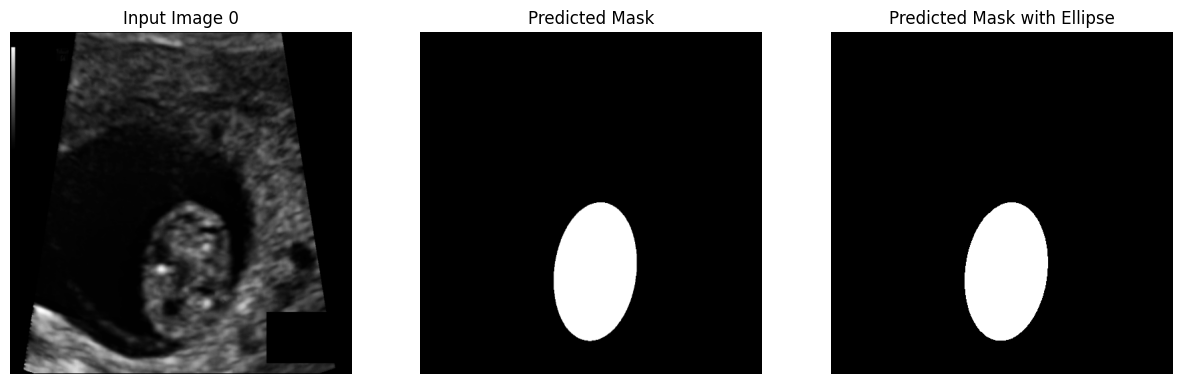

In [14]:
indices_to_remove_largest_shape = []
indices_to_keep_largest_shape = []
indices_to_shrink_mask_weak = []
indices_to_shrink_mask_medium = []
indices_to_shrink_mask_strong = []
indices_to_enlarge_white_shapes = []
indices_to_enlarge_white_shapes_strong = []
indices_to_connect_shapes = []
indices_to_center_circle = []
indices_to_mid_center_circle = []
indices_to_big_center_circle = []
indices_to_add_higher_center_circle = []
indices_to_add_lower_center_circle = []
indices_to_ignore_image = []

# Define the range you want to iterate over
start_index = 0
end_index = 1

def process_mask(pred_mask, index):
    if index in indices_to_remove_largest_shape:
        pred_mask = keep_second_largest_shape(pred_mask)
    if index in indices_to_center_circle:
        pred_mask = add_center_circle(pred_mask)
    if index in indices_to_mid_center_circle:
        pred_mask = add_center_circle(pred_mask, 155)
    if index in indices_to_big_center_circle:
        pred_mask = add_center_circle(pred_mask, 180)
    if index in indices_to_add_lower_center_circle:
        pred_mask = add_lower_center_ellipse(pred_mask)
    if index in indices_to_add_higher_center_circle:
        pred_mask = add_higher_center_circle(pred_mask)
    if index in indices_to_shrink_mask_weak:
        pred_mask = shrink_largest_shape(pred_mask)
    if index in indices_to_shrink_mask_medium:
        pred_mask = shrink_largest_shape(pred_mask, 30)
    if index in indices_to_shrink_mask_strong:
        pred_mask = shrink_largest_shape(pred_mask, 40)
    if index in indices_to_connect_shapes:
        pred_mask = connect_all_shapes(pred_mask)
    if index in indices_to_keep_largest_shape:
        pred_mask = keep_largest_shape(pred_mask)
    if index in indices_to_enlarge_white_shapes:
        pred_mask = enlarge_all_shapes(pred_mask, 30)
    if index in indices_to_enlarge_white_shapes_strong:
        pred_mask = enlarge_all_shapes(pred_mask, 50)
    
    return pred_mask

mask_dir_path = "/kaggle/input/testingdataset/images_mask"

def get_existing_mask(index):
    if 'mask_filename' in test_df.columns and os.path.isdir(mask_dir_path):
        mask_filename = test_df.iloc[index]['mask_filename']
        mask_path = os.path.join(mask_dir_path, mask_filename)
        
        if os.path.isfile(mask_path):
            existing_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            resized_mask = cv2.resize(existing_mask, (512, 512))
            return mask_filename, resized_mask
        
    return None, None

# Ensure end_index does not exceed the length of the dataset
end_index = min(end_index, len(test_dataset))

for i in range(start_index, end_index):
    sample = test_dataset[i]
    x = sample['image']
    file_name = sample['f_name']

    # Convert the tensor to a NumPy array
    img_x = x.numpy().reshape(img_size, img_size)

    # Prepare the input tensor and make a prediction
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        model.eval()
        pred_mask = model(x)
        pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy().reshape(img_size, img_size)
        
    if i in indices_to_ignore_image:
        continue
    
    pred_mask = process_mask(pred_mask, i)
    
    # Get existing mask if available
    _ , existing_mask = get_existing_mask(i)
    if existing_mask is not None:
        pred_mask = existing_mask
        ellipse = test_ellipse(pred_mask.astype(np.uint8))
    else:
        ellipse = test_ellipse((pred_mask * 255).astype(np.uint8))

    im_mask = cv2.ellipse(np.zeros_like((pred_mask * 255).astype(np.uint8)), ellipse, (255, 255, 255), -1)

    # Display images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title(f'Input Image {i}')
    plt.imshow(img_x, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask with Ellipse')
    plt.imshow(cv2.cvtColor(im_mask, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

## Circumference calculation

In [15]:
from tqdm import tqdm

# Create a directory to save the masks
mask_dir = dirPath + 'masks/'
os.makedirs(mask_dir, exist_ok=True)

# Create the DataFrame for the submission
submission = pd.DataFrame(columns=['filename', 'Head_Circumference_cm', 'Head_Circumference_mm', 
                                   'pixel size(mm)', 'OFD', 'BPD', 'mask_filename'])

total_samples = len(test_dataset)

for i in tqdm(range(total_samples), desc="Processing samples"):
    sample = test_dataset[i]
    x = sample['image']
    file_name = sample['f_name']
    
    # Get existing mask if available
    mask_filename, existing_mask = get_existing_mask(i)
    
    if existing_mask is None:
        # Convert the tensor to a NumPy array
        img_x = x.numpy().reshape(img_size, img_size)

        # Prepare the input tensor and make a prediction
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            model.eval()
            pred_mask = model(x)
            pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy().reshape(img_size, img_size)

        if i in indices_to_ignore_image:
            continue

        pred_mask = process_mask(pred_mask, i)
    
    if existing_mask is not None:
        pred_mask = existing_mask
    else:
        # Convert pred_mask to uint8 before resizing
        ellipse = test_ellipse((pred_mask * 255).astype(np.uint8))
        img_mask = cv2.ellipse(np.zeros_like((pred_mask * 255).astype(np.uint8)), ellipse, (255, 255, 255), -1)

        # Save the mask
        mask_filename = f'mask_{file_name}'
        mask_filepath = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_filepath, img_mask)
    
    resized_pred_mask = cv2.resize(pred_mask.astype(np.uint8), (933, 850), interpolation=cv2.INTER_LINEAR)
    if existing_mask is not None:
        resized_ellipse = test_ellipse((resized_pred_mask).astype(np.uint8))
    else:
        resized_ellipse = test_ellipse((resized_pred_mask * 255).astype(np.uint8))
    circumference, OFD, BPD = calculate_circumference(resized_ellipse, i, test_df)
    predicted_val = np.round(circumference, 4)
    
    # Add the result to the DataFrame directly
    submission.loc[len(submission)] = {
        'filename': file_name,
        'pixel size(mm)': test_df.at[i, 'pixel size(mm)'],
        'Head_Circumference_cm': predicted_val,
        'Head_Circumference_mm': predicted_val * 10,
        'OFD': OFD,
        'BPD': BPD,
        'mask_filename': mask_filename
    }

# Display the head of the submission DataFrame
submission.head()

Processing samples: 100%|██████████| 999/999 [00:26<00:00, 37.70it/s]


,filename,Head_Circumference_cm,Head_Circumference_mm,pixel size(mm),OFD,BPD,mask_filename
0,000_HC.png,4.430,44.30,0.069136,23.9,15.4,000_HC_Mask.png
1,001_HC.png,5.681,56.81,0.089659,25.7,23.3,001_HC_Mask.png
2,012_HC.png,5.940,59.40,0.083460,29.3,22.7,012_HC_Mask.png
3,004_HC.png,5.981,59.81,0.061240,30.7,21.6,004_HC_Mask.png
4,014_3HC.png,6.026,60.26,0.077308,28.1,24.1,014_3HC_Mask.png


## Download measurements and masks

In [17]:
def zip_images(directory, output_filename):
    # Create a ZipFile object
    with zipfile.ZipFile(output_filename, 'w') as zipf:
        # Walk through the directory
        for foldername, subfolders, filenames in os.walk(directory):
            for filename in filenames:
                # Check if the file is an image (you can add more extensions if needed)
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                    # Create the full file path
                    file_path = os.path.join(foldername, filename)
                    # Add file to the zip
                    zipf.write(file_path, os.path.relpath(file_path, directory))

In [18]:
output_zipfile = os.path.join(dirPath, "images_masks.zip")
zip_images(mask_dir, output_zipfile)

In [16]:
csv_file_path = os.path.join('/kaggle/working/', "result.csv")
submission.to_csv(csv_file_path, index=False)

## Filter data (optional)

In [ ]:
submission_filtered = submission.copy()

# Define the range you want to exclude
lower_bound = 16
upper_bound = 29

# Filter the DataFrame to remove rows within the specified range
submission_filtered = submission[
    (submission['Head_Circumference_cm'] > upper_bound)
].reset_index(drop=True)

# Define source and destination directories
dest_dir = dirPath + 'gan_images_to_keep/'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Copy images and update the DataFrame
new_filenames = []
for i, row in submission_filtered.iterrows():
    old_filename = row['filename']
    new_filename = f'gan_img_{i+1}.png'
    old_filepath = os.path.join(img_dir, old_filename)
    new_filepath = os.path.join(dest_dir, new_filename)
    
    # Copy the image file
    shutil.copyfile(old_filepath, new_filepath)
    
    # Add the new filename to the list
    new_filenames.append(new_filename)

# Update the DataFrame with the new filenames
submission_filtered['filename'] = new_filenames

# Save the filtered DataFrame to a CSV file
csv_file_path = os.path.join(dirPath, "filtered_result.csv")
submission_filtered.to_csv(csv_file_path, index=False)

In [ ]:
# Define the directory containing the images and the output zip file name
output_zipfile = os.path.join(dirPath, "images.zip")
zip_images(dest_dir, output_zipfile)

# zip masks
output_zipfile = os.path.join(dirPath, "images_masks.zip")
zip_images(mask_dir, output_zipfile)

## Test mask resize for prediction (optional)
#### To get accurate circumference, we need to resize the model output from 512x512 to (width, height). If you set `create_image_df` to the path of training set images and load its scv, you can run the code below to check the accuracy of prediction using the scale (933, 850).
#### To test different choices of width and height, you can use the code utlizing optuna to search for the best pair.

In [ ]:
from tqdm import tqdm

total_samples = len(test_dataset)
correct_predictions = 0

# Use tqdm to create a loading bar
for i in tqdm(range(total_samples), desc="Processing samples"):
    sample = test_dataset[i]
    x = sample['image']
    file_name = sample['f_name']

    # Convert the tensor to a NumPy array
    img_x = x.numpy().reshape(img_size, img_size)

    # Prepare the input tensor and make a prediction
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        model.eval()
        pred_mask = model(x)
        pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy().reshape(img_size, img_size)

        # Apply the ellipse fitting function
        resized_pred_mask = cv2.resize(pred_mask, (933, 850), interpolation=cv2.INTER_LINEAR)
        ellipse = test_ellipse((resized_pred_mask * 255).astype(np.uint8))
        circumference, _, _ = calculate_circumference(ellipse, i, test_df)
        predicted_val = np.round(circumference, 4)
    
    # Get the actual circumference from test_df
    actual_val = test_df.at[i, 'Head_Circumference_cm']
    
    #print(f"actual: {actual_val} predictions: {predicted_val}")
    
    # Check if the prediction is within 1 cm of the actual value
    if abs(predicted_val - actual_val) <= 1:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_samples
print("Overall Accuracy:", accuracy)

In [ ]:
import optuna
import optuna.visualization as vis

def objective(trial):
    # Define the search space for (width, height)
    width = trial.suggest_int('width', 900, 1000)
    height = trial.suggest_int('height', 800, 900)
    
    total_samples = len(test_dataset)
    correct_predictions = 0
    
    for i in range(total_samples):
        sample = test_dataset[i]
        x = sample['image']
        file_name = sample['f_name']

        # Convert the tensor to a NumPy array
        img_x = x.numpy().reshape(img_size, img_size)

        # Prepare the input tensor and make a prediction
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            model.eval()
            pred_mask = model(x)
            pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy().reshape(img_size, img_size)

            # Apply the ellipse fitting function
            resized_pred_mask = cv2.resize(pred_mask, (width, height), interpolation=cv2.INTER_LINEAR)
            ellipse = test_ellipse((resized_pred_mask  * 255).astype(np.uint8))
            circumference, _, _ = calculate_circumference(ellipse, i, test_df)
            predicted_val = np.round(circumference, 4)

        # Get the actual circumference from test_df
        actual_val = test_df.at[i, 'Head_Circumference_cm']

        # Check if the prediction is within 1 cm of the actual value
        if abs(predicted_val - actual_val) <= 0.5:
            correct_predictions += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    
    # Return negative accuracy because Optuna minimizes the objective
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found
best_params = study.best_params
print("Best parameters:", best_params)

# Visualize the optimization process
fig = vis.plot_slice(study, params=["width", "height"])
fig.show()